---
# Install the required packages

If needed install the following packages:

In [1]:
!pip install datasets transformers imbalanced-learn evaluate

---
# Imports

In [1]:
from datasets import load_dataset

# Write your code here. Add as many boxes as you need.

---
# Laboratory Exercise - Run Mode (8 points)

## Introduction

This laboratory assignment's primary objective is to fine-tune a pre-trained language model for detection of toxic sentences (binary classification). 

The dataset contains two attributes: 
- `text`: The sentence which needs to be classified in to toxic/non-toxic
- `label`: 0/1 indicator if the given sentence is toxic

**Note: You are required to perform this laboratory assignment on your local machine.**

# Read the data

The dataset reading is given. Just run the following 2 cells.

**DO NOT MODIFY IT! Just analyse how the data reading was performed, as in the future this part won't be given.**

In [2]:
dataset = load_dataset(
    'csv', 
    data_files={'train': 'data/train.tsv', 'val': 'data/val.tsv','test': 'data/test.tsv'},
    delimiter='\t'
)

**The prediction target column MUST be named 'label' in the dataset !**

See the dataset structure:

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 3130
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3132
    })
})

---
# Natural Language Processing

## Generate the Tokenizer and Data Collator

For the purposes of this lab you will be using `DistilBertTokenizer` and `DataCollatorWithPadding`.

In [5]:
# Write your code here. Add as many boxes as you need.

In [4]:
from transformers import DistilBertTokenizer, DataCollatorWithPadding

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

## Tokenize the dataset

For the purposes of lowering the amount of computing set the `max_length` parameter to 15.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [5]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=15)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [6]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3130
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3132
    })
})

## Define the model

The required model for this lab is the `DistilBertForSequenceClassification`.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [7]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define the training arguments

For lowering the compute time I recommend using the following parameters:
- per_device_train_batch_size=128
- per_device_eval_batch_size=128
- **num_train_epochs=1**

In [8]:
# Write your code here. Add as many boxes as you need.

In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    metric_for_best_model="f1",
)

## Load the metrics

Load the best metric for the this specific problem.

In [9]:
# Write your code here. Add as many boxes as you need.

In [9]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

### Define the function to compute the metrics

In [10]:
# Write your code here. Add as many boxes as you need.

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

## Generate the Trainer object

In [11]:
# Write your code here. Add as many boxes as you need.

In [11]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

## Train the model

Use the trainer to train the model.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.626725,0.694432


TrainOutput(global_step=8, training_loss=0.6736516952514648, metrics={'train_runtime': 32.957, 'train_samples_per_second': 30.343, 'train_steps_per_second': 0.243, 'total_flos': 3880880820000.0, 'train_loss': 0.6736516952514648, 'epoch': 1.0})

---
# Evaluate the model

## Generate predictions for the test set

In [ ]:
# Write your code here. Add as many boxes as you need.

In [23]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions)

PredictionOutput(predictions=array([[ 0.19197664, -0.37786666],
       [-0.59452295,  0.9316391 ],
       [ 0.2991601 , -0.32048425],
       ...,
       [ 0.33850068, -0.43059987],
       [ 0.4736089 , -0.32751763],
       [ 0.08314463, -0.28398475]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.4002592861652374, 'test_f1': 0.8723060060029298, 'test_runtime': 11.1522, 'test_samples_per_second': 280.843, 'test_steps_per_second': 2.242})


## Extract the predictions (class 0 or 1) from the logits

In [14]:
# Write your code here. Add as many boxes as you need.

In [24]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

## Analyze the performance of the model

In [ ]:
# Write your code here. Add as many boxes as you need.

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1566
           1       0.93      0.80      0.86      1566

    accuracy                           0.87      3132
   macro avg       0.88      0.87      0.87      3132
weighted avg       0.88      0.87      0.87      3132



Text(0.5, 1.0, 'Confusion Matrix')

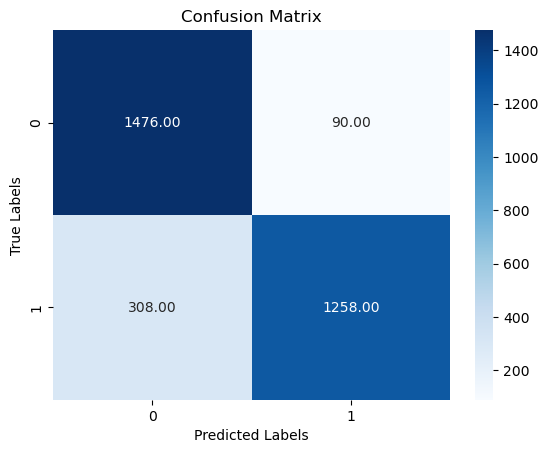

In [26]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify if a given text is **toxic** or not. Use TF-IDF vectorization to convert text into numerical features and train a `MultinomialNB` model. If needed use `RandomUnderSampler()`. Compare the results with the transformer model.

In [16]:
# Write your code here. Add as many boxes as you need.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(dataset["train"]["text"])
y = dataset["train"]["label"]

---

In [30]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [32]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tv = TfidfVectorizer(binary=True, norm=None, use_idf=False, smooth_idf=False, lowercase=True, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b', min_df=1, max_df=1.0, max_features=None, ngram_range=(1, 1))

model = make_pipeline(tv, MultinomialNB())
model.fit(dataset['train']['text'], dataset['train']['label'])

y_pred = model.predict(dataset['test']['text'])


In [36]:
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.72      0.76        99
           1       0.75      0.84      0.79        99

    accuracy                           0.78       198
   macro avg       0.78      0.78      0.78       198
weighted avg       0.78      0.78      0.78       198

